<a href="https://colab.research.google.com/github/chominyeong/NewsSentimentStock_StockSurge/blob/main/%EA%B0%80%EC%84%A4%EA%B2%80%EC%A6%9D1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 가설
1. 뉴스 감성은 주가의 변동에 영향을 미칠 것이다.
2. 뉴스 감성은 주가의 종가에 영향을 미칠 것이다.

In [ ]:
# # 설치 후 런타임 다시 시작, 다시 시작할 때는 실행 안해도 됨
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import ttest_ind
import numpy as np

In [ ]:
# 나눔 바른 고딕 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
stock_news_df = pd.read_csv("/content/drive/MyDrive/성동3기 전Z전능 데이터분석가 과정/python 프로젝트 떡상/가설 검증/stock_news_df.csv")

In [ ]:
# 날짜 format 변경
stock_news_df['date'] = pd.to_datetime(stock_news_df['date'])

# 반올림
stock_news_df['종가'] = round(stock_news_df['종가'], 2)
stock_news_df['시가'] = round(stock_news_df['시가'], 2)
stock_news_df['고가'] = round(stock_news_df['고가'], 2)
stock_news_df['저가'] = round(stock_news_df['저가'], 2)

stock_news_df['keyword'].replace(['전기차', 'ev', 'electric vehicle'], '전기 자동차', inplace=True)
stock_news_df['keyword'].replace('Elon Musk', '일론 머스크', inplace=True)
stock_news_df['keyword'].replace('Tesla', '테슬라', inplace=True)
stock_news_df['keyword'].replace(['LG 엔솔', 'lg energy solution', 'LG 에너지솔루션'], 'LG 에너지 솔루션', inplace=True)
stock_news_df['keyword'].replace(['panasonic battery', '파나소닉 배터리'], '파나소닉', inplace=True)
stock_news_df['keyword'].replace('Lithium', '리튬', inplace=True)

<ipython-input-84-5331887308c0>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_news_df['keyword'].replace(['전기차', 'ev', 'electric vehicle'], '전기 자동차', inplace=True)


## LG 에너지 솔루션

#### 변동률

In [ ]:
# LG 엔솔 주가 데이터
lg_stock = stock_news_df.query('기업명 == "LG 에너지 솔루션"')[['기업명', 'date', '종가', '변동 %', '거래량']].drop_duplicates().reset_index(drop=True)

# LG 엔솔 뉴스 데이터
news = stock_news_df[['keyword', 'summary','date', '감성점수', '감성결과']].drop_duplicates(keep='first', ignore_index = True)
lg_news = news.query('keyword in ["LG 에너지 솔루션"]').reset_index(drop=True)

1. 주가 변동률 상/하위 10% 날짜 선정

In [ ]:
# 주가 데이터 불러오기 (tesla_stock 사용)
df = lg_stock.copy()

# 변동률 기준 상위/하위 10% 찾기
top_10_perc = np.percentile(df["변동 %"], 90)  # 상위 10% 기준값
bottom_10_perc = np.percentile(df["변동 %"], 10)  # 하위 10% 기준값

# 급등/급락 날짜 필터링
high_volatility_days = df[(df["변동 %"] >= top_10_perc) | (df["변동 %"] <= bottom_10_perc)]["date"]
low_volatility_days = df[(df["변동 %"] < top_10_perc) & (df["변동 %"] > bottom_10_perc)]["date"]

print(f"급등/급락 날짜 개수: {len(high_volatility_days)}, 변동률 적은 날짜 개수: {len(low_volatility_days)}")

급등/급락 날짜 개수: 24, 변동률 적은 날짜 개수: 96


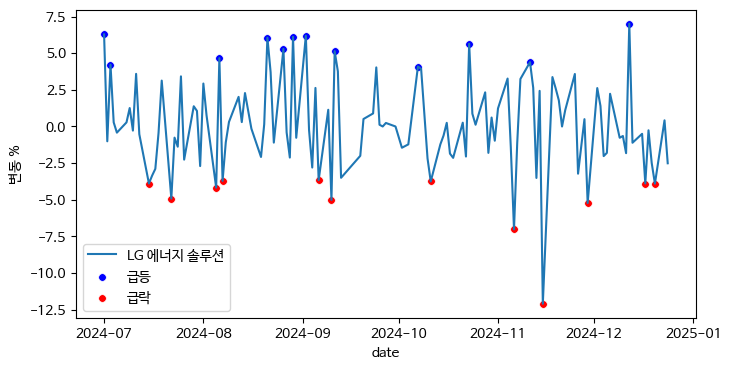

In [ ]:
급등 = df[(df["변동 %"] >= top_10_perc)]["date"]
급락 = df[(df["변동 %"] <= bottom_10_perc)]["date"]

# 기본 선 그래프
plt.figure(figsize=(8, 4))
sns.lineplot(data=lg_stock, x='date', y='변동 %', hue='기업명', color = 'black')

# 특정 날짜에 빨간 점을 찍는 그래프
sns.scatterplot(data=lg_stock[lg_stock['date'].isin(급등)],
                x='date', y='변동 %', color='blue', s=30, label='급등')

sns.scatterplot(data=lg_stock[lg_stock['date'].isin(급락)],
                x='date', y='변동 %', color='red', s=30, label='급락')


# 그래프 표시
# plt.legend()
plt.show()


2. 해당 날짜들의 평균 감성 점수 비교 (t-검정)

In [ ]:
from scipy.stats import ttest_ind

# 뉴스 데이터 불러오기 (tesla_news 사용)
news_df = lg_news.copy()

# 급등/급락 날짜의 뉴스 감성점수
high_vol_news = news_df[news_df["date"].isin(high_volatility_days)]["감성점수"]
low_vol_news = news_df[news_df["date"].isin(low_volatility_days)]["감성점수"]

# 독립표본 t-검정 수행
t_stat, p_value = ttest_ind(high_vol_news, low_vol_news, equal_var=False)  # 등분산 가정 X

print(f"t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 유의수준 0.05 기준으로 가설 검정
if p_value < 0.05:
    print("✅ 주가 변동이 큰 날과 작은 날의 뉴스 감성 차이가 유의미함 (H₀ 기각)")
else:
    print("❌ 뉴스 감성이 주가 변동성과 관계없음 (H₀ 채택)")

t-검정 통계량: 0.2011, p-value: 0.8407
❌ 뉴스 감성이 주가 변동성과 관계없음 (H₀ 채택)


3. 시각화

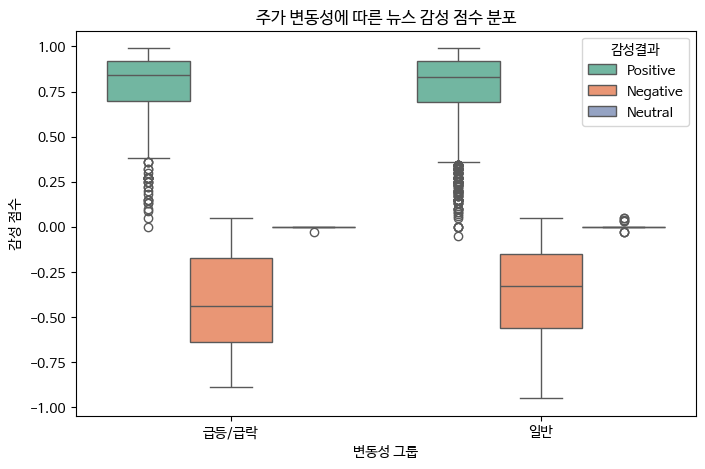

In [ ]:
# 데이터 프레임 생성 (분포 비교용)
plot_df = news_df.copy()
plot_df["변동성 그룹"] = plot_df["date"].apply(lambda x: "급등/급락" if x in high_volatility_days.values else "일반")

# 박스플롯 그리기
plt.figure(figsize=(8, 5))
sns.boxplot(x="변동성 그룹", y="감성점수", data=plot_df, palette='Set2', hue = '감성결과')
plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
plt.xlabel("변동성 그룹")
plt.ylabel("감성 점수")
plt.show()

그룹 3개 기준

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# 데이터프레임 불러오기
stock_df = lg_stock.copy()  # 테슬라 주식 데이터
news_df = lg_news.copy()   # 테슬라 뉴스 데이터

# 주가 변동성 기준 설정 (상위/하위 10% 기준으로 급등/급락 구분)
high_threshold = stock_df["변동 %"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["변동 %"].quantile(0.1)   # 하위 10% 기준

# 급등/급락/일반 그룹 설정
def categorize_price_change(row):
    if row["변동 %"] >= high_threshold:
        return "급등"
    elif row["변동 %"] <= low_threshold:
        return "급락"
    else:
        return "일반"

# 주가 변동성 그룹을 먼저 계산
stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

# 뉴스 데이터와 주가 변동성 데이터 병합
merged_df = pd.merge(news_df, stock_df[["date", "변동성 그룹"]], on="date", how="inner")

# # 급등/급락/일반 그룹에 따른 뉴스 감성 점수 비교
# plt.figure(figsize=(8, 5))
# sns.boxplot(x="변동성 그룹", y="감성점수", data=merged_df, palette=["red", "green", "blue"])
# plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
# plt.xlabel("변동성 그룹")
# plt.ylabel("감성 점수")
# plt.show()

# 독립표본 t-검정: 급등 vs 급락, 급등 vs 일반, 급락 vs 일반 비교
# 급등 vs 급락
high_volatility_news = merged_df[merged_df["변동성 그룹"] == "급등"]["감성점수"]
low_volatility_news = merged_df[merged_df["변동성 그룹"] == "급락"]["감성점수"]

t_stat, p_value = ttest_ind(high_volatility_news, low_volatility_news, equal_var=False)
print(f"급등 vs 급락 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급등 vs 일반
normal_volatility_news = merged_df[merged_df["변동성 그룹"] == "일반"]["감성점수"]
t_stat, p_value = ttest_ind(high_volatility_news, normal_volatility_news, equal_var=False)
print(f"급등 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급락 vs 일반
t_stat, p_value = ttest_ind(low_volatility_news, normal_volatility_news, equal_var=False)
print(f"급락 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")


급등 vs 급락 t-검정 통계량: 0.5865, p-value: 0.5578
급등 vs 일반 t-검정 통계량: 0.5329, p-value: 0.5944
급락 vs 일반 t-검정 통계량: -0.2516, p-value: 0.8015


하나의 함수로 만들기

In [ ]:
def volatility_stock_and_news(stock, news):
    # 1. 주가 변동성 분석
    stock_df = stock.copy()

    # 변동률 기준 상위/하위 10% 찾기
    top_10_perc = np.percentile(stock_df["변동 %"], 90)  # 상위 5% 기준값
    bottom_10_perc = np.percentile(stock_df["변동 %"], 10)  # 하위 5% 기준값

    # 급등/급락 날짜 필터링
    high_volatility_days = stock_df[(stock_df["변동 %"] >= top_10_perc) | (stock_df["변동 %"] <= bottom_10_perc)]["date"]
    low_volatility_days = stock_df[(stock_df["변동 %"] < top_10_perc) & (stock_df["변동 %"] > bottom_10_perc)]["date"]

    print(f"급등/급락 날짜 개수: {len(high_volatility_days)}, 변동률 적은 날짜 개수: {len(low_volatility_days)}")

    # 2. 기본 선 그래프
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=stock_df, x='date', y='변동 %', hue='기업명', palette=['black'], linewidth=0.8)


    급등 = stock_df[(stock_df["변동 %"] >= top_10_perc)]["date"]
    급락 = stock_df[(stock_df["변동 %"] <= bottom_10_perc)]["date"]

    # 특정 날짜에 빨간 점을 찍는 그래프
    sns.scatterplot(data=stock_df[stock_df['date'].isin(급등)],
                    x='date', y='변동 %', color='blue', s=30, label='급등')

    sns.scatterplot(data=stock_df[stock_df['date'].isin(급락)],
                    x='date', y='변동 %', color='red', s=30, label='급락')

    plt.title("주가 변동성 분석")
    plt.xlabel("날짜")
    plt.ylabel("변동 %")
    plt.legend()
    plt.show()


    # 3. 뉴스 감성 분석 (t-검정)
    news_df = news.copy()

    # 급등/급락 날짜의 뉴스 감성점수
    high_vol_news = news_df[news_df["date"].isin(high_volatility_days)]["감성점수"]
    low_vol_news = news_df[news_df["date"].isin(low_volatility_days)]["감성점수"]

    # 독립표본 t-검정 수행
    t_stat, p_value = ttest_ind(high_vol_news, low_vol_news, equal_var=False)  # 등분산 가정 X

    print(f"t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

    # 유의수준 0.05 기준으로 가설 검정
    if p_value < 0.05:
        print("✅ 주가 변동이 큰 날과 작은 날의 뉴스 감성 차이가 유의미함 (H₀ 기각)")
    else:
        print("❌ 뉴스 감성이 주가 변동성과 관계없음 (H₀ 채택)")

    # 4. 박스플롯 그리기
    plot_df = news_df.copy()
    plot_df["변동성 그룹"] = plot_df["date"].apply(lambda x: "급등/급락" if x in high_volatility_days.values else "일반")

    plt.figure(figsize=(10, 5))
    sns.boxplot(x="변동성 그룹", y="감성점수", data=plot_df, palette='Set2', hue = '감성결과')
    plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
    plt.xlabel("변동성 그룹")
    plt.ylabel("감성 점수")
    plt.show()

급등/급락 날짜 개수: 24, 변동률 적은 날짜 개수: 96


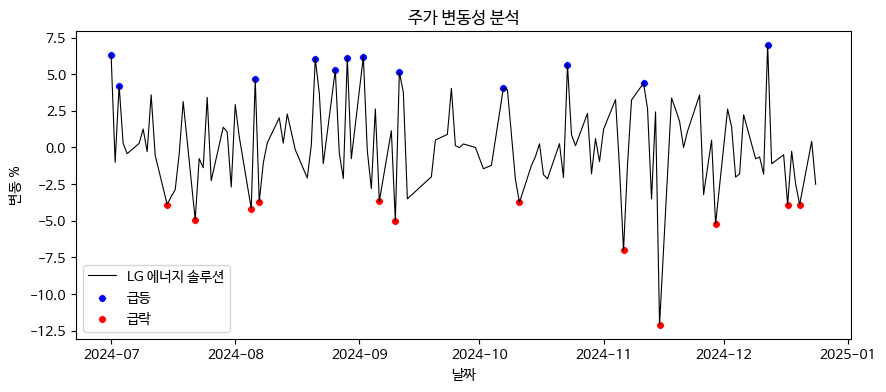

t-검정 통계량: 0.2011, p-value: 0.8407
❌ 뉴스 감성이 주가 변동성과 관계없음 (H₀ 채택)


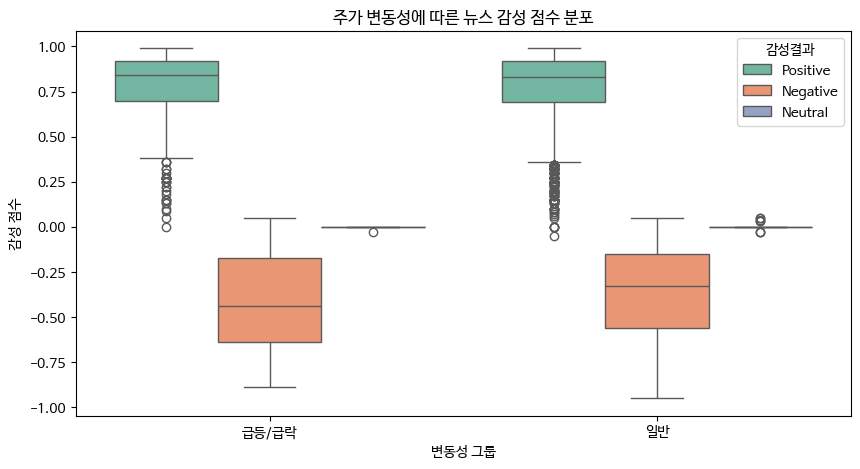

In [ ]:
volatility_stock_and_news(lg_stock, lg_news)

#### 종가

In [ ]:
# 뉴스 데이터 복사
news_df = lg_news.copy()
# 종가 데이터 가져오기
stock_df = lg_stock.copy()

# 고점/저점 기준 설정 (상위 10%, 하위 10%)
high_threshold = stock_df["종가"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["종가"].quantile(0.1)   # 하위 10% 기준

high_price_days = stock_df[stock_df["종가"] >= high_threshold]["date"]
low_price_days = stock_df[stock_df["종가"] <= low_threshold]["date"]

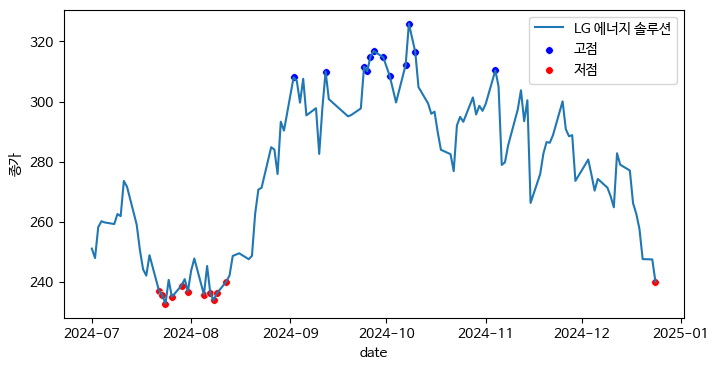

In [ ]:
# 기본 선 그래프
plt.figure(figsize=(8, 4))
sns.lineplot(data=stock_df, x='date', y='종가', hue='기업명', color = 'black')

# 특정 날짜에 빨간 점을 찍는 그래프
sns.scatterplot(data=stock_df[stock_df['date'].isin(high_price_days)],
                x='date', y='종가', color='blue', s=30, label='고점')

sns.scatterplot(data=stock_df[stock_df['date'].isin(low_price_days)],
                x='date', y='종가', color='red', s=30, label='저점')


# 그래프 표시
# plt.legend()
plt.show()

In [ ]:
# 뉴스 감성 점수 필터링
high_price_news = news_df[news_df["date"].isin(high_price_days)]["감성점수"]
low_price_news = news_df[news_df["date"].isin(low_price_days)]["감성점수"]

# 독립표본 t-검정 수행
t_stat, p_value = ttest_ind(high_price_news, low_price_news, equal_var=False)

# 결과 출력
print(f"t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)")
else:
    print("❌ 종가 수준과 뉴스 감성은 관계 없음 (H₀ 채택)")

t-검정 통계량: 4.4612, p-value: 0.0000
✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)


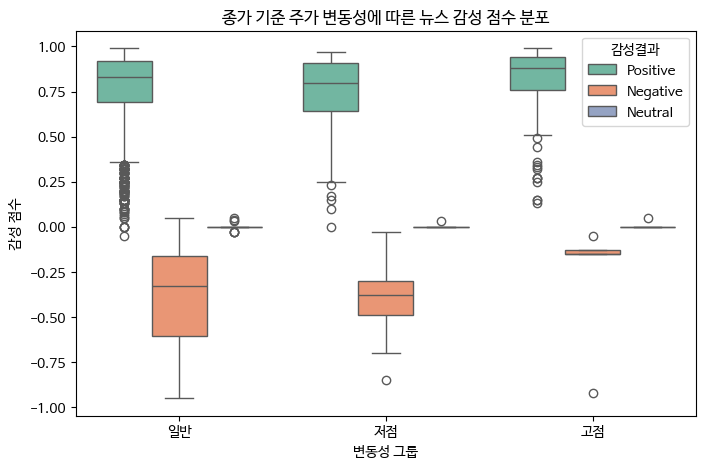

In [ ]:
# 데이터 프레임 생성 (뉴스 데이터 복사)
plot_df = news_df.copy()

# 종가 기준으로 급등/급락/일반 그룹 나누기
high_threshold = stock_df["종가"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["종가"].quantile(0.1)   # 하위 10% 기준

# 급등/급락/일반 그룹 정의
def categorize_price_change(row):
    if row["종가"] >= high_threshold:
        return "고점"
    elif row["종가"] <= low_threshold:
        return "저점"
    else:
        return "일반"

# 종가 기준으로 변동성 그룹 생성
stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

# 종가 기준으로 변동성 그룹을 뉴스 데이터에 추가
plot_df["변동성 그룹"] = plot_df["date"].apply(lambda x: stock_df[stock_df["date"] == x]["변동성 그룹"].values[0] if len(stock_df[stock_df["date"] == x]) > 0 else "일반")

# 박스플롯 그리기
plt.figure(figsize=(8, 5))
sns.boxplot(x="변동성 그룹", y="감성점수", data=plot_df, palette='Set2', hue="감성결과")
plt.title("종가 기준 주가 변동성에 따른 뉴스 감성 점수 분포")
plt.xlabel("변동성 그룹")
plt.ylabel("감성 점수")
plt.show()

하나의 함수로 만들기

In [ ]:
def close_stock_and_news(stock, news):

    # 뉴스 데이터 복사
    news_df = news.copy()
    # 종가 데이터 가져오기
    stock_df = stock.copy()

    # 고점/저점 기준 설정 (상위 10%, 하위 10%)
    high_threshold = stock_df["종가"].quantile(0.9)  # 상위 10% 기준
    low_threshold = stock_df["종가"].quantile(0.1)   # 하위 10% 기준

    high_price_days = stock_df[stock_df["종가"] >= high_threshold]["date"]
    low_price_days = stock_df[stock_df["종가"] <= low_threshold]["date"]

    print(f"고점 날짜 개수: {len(high_price_days)}, 저점 날짜 개수: {len(low_price_days)}")

    # 기본 선 그래프
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=stock_df, x='date', y='종가', hue='기업명', palette=['black'], linewidth=0.8)

    # 특정 날짜에 빨간 점을 찍는 그래프
    sns.scatterplot(data=stock_df[stock_df['date'].isin(high_price_days)],
                    x='date', y='종가', color='blue', s=30, label='고점')

    sns.scatterplot(data=stock_df[stock_df['date'].isin(low_price_days)],
                    x='date', y='종가', color='red', s=30, label='저점')
    plt.show()


    # 뉴스 감성 점수 필터링
    high_price_news = news_df[news_df["date"].isin(high_price_days)]["감성점수"]
    low_price_news = news_df[news_df["date"].isin(low_price_days)]["감성점수"]

    # 독립표본 t-검정 수행
    t_stat, p_value = ttest_ind(high_price_news, low_price_news, equal_var=False)

    # 결과 출력
    print(f"t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)")
    else:
        print("❌ 종가 수준과 뉴스 감성은 관계 없음 (H₀ 채택)")


    # 종가 기준으로 급등/급락/일반 그룹 나누기
    high_threshold = stock_df["종가"].quantile(0.9)  # 상위 10% 기준
    low_threshold = stock_df["종가"].quantile(0.1)   # 하위 10% 기준

    # 급등/급락/일반 그룹 정의
    def categorize_price_change(row):
        if row["종가"] >= high_threshold:
            return "고점"
        elif row["종가"] <= low_threshold:
            return "저점"
        else:
            return "일반"

    # 종가 기준으로 변동성 그룹 생성
    stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

    # 종가 기준으로 변동성 그룹을 뉴스 데이터에 추가
    plot_df["변동성 그룹"] = plot_df["date"].apply(lambda x: stock_df[stock_df["date"] == x]["변동성 그룹"].values[0] if len(stock_df[stock_df["date"] == x]) > 0 else "일반")

    # 박스플롯 그리기
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="변동성 그룹", y="감성점수", data=plot_df, palette='Set2', hue="감성결과")
    plt.title("종가 기준 주가 변동성에 따른 뉴스 감성 점수 분포")
    plt.xlabel("변동성 그룹")
    plt.ylabel("감성 점수")
    plt.show()

고점 날짜 개수: 12, 저점 날짜 개수: 12


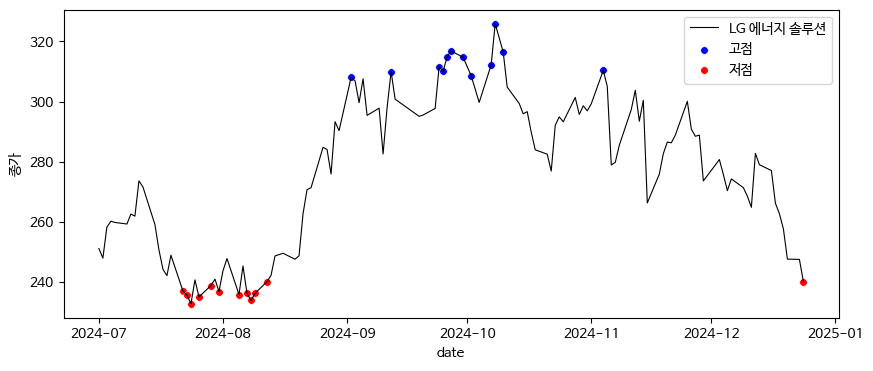

t-검정 통계량: 4.4612, p-value: 0.0000
✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)


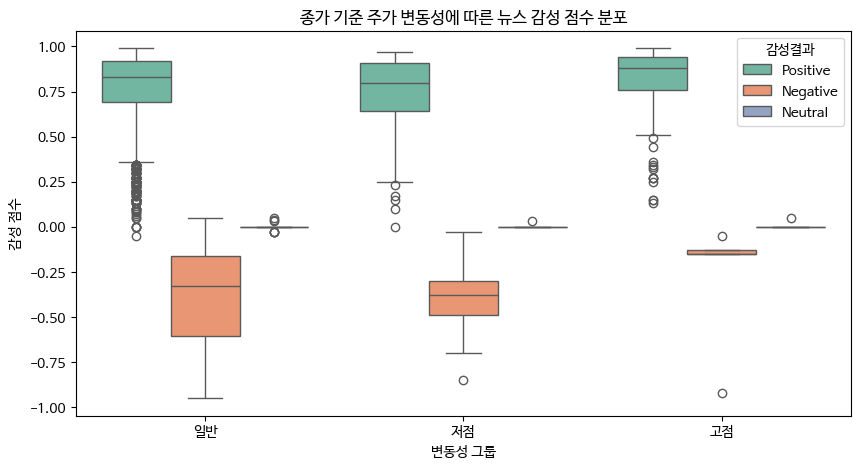

In [ ]:
close_stock_and_news(lg_stock, lg_news)

## 테슬라

In [ ]:
# tesla 주가 데이터
tesla_stock = stock_news_df.query('기업명 == "테슬라"')[['기업명', 'date', '종가', '변동 %', '거래량']].drop_duplicates().reset_index(drop=True)

# tesla 뉴스 데이터
tesla_news = news.query('keyword in ["일론 머스크", "테슬라"]').reset_index(drop=True)

#### 변동률

급등/급락 날짜 개수: 26, 변동률 적은 날짜 개수: 98


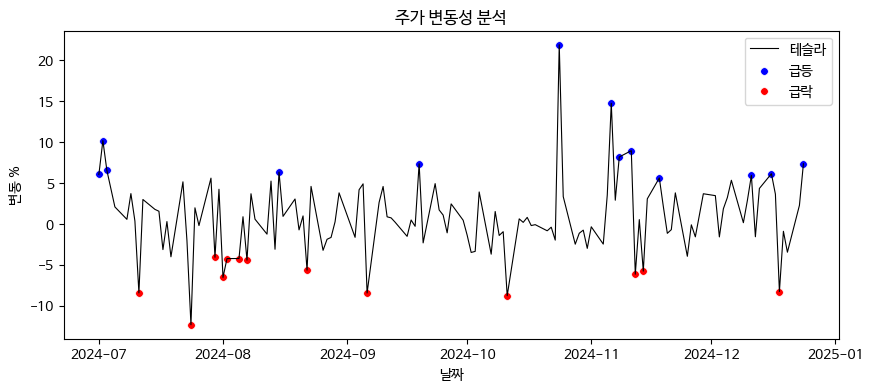

t-검정 통계량: 5.9307, p-value: 0.0000
✅ 주가 변동이 큰 날과 작은 날의 뉴스 감성 차이가 유의미함 (H₀ 기각)


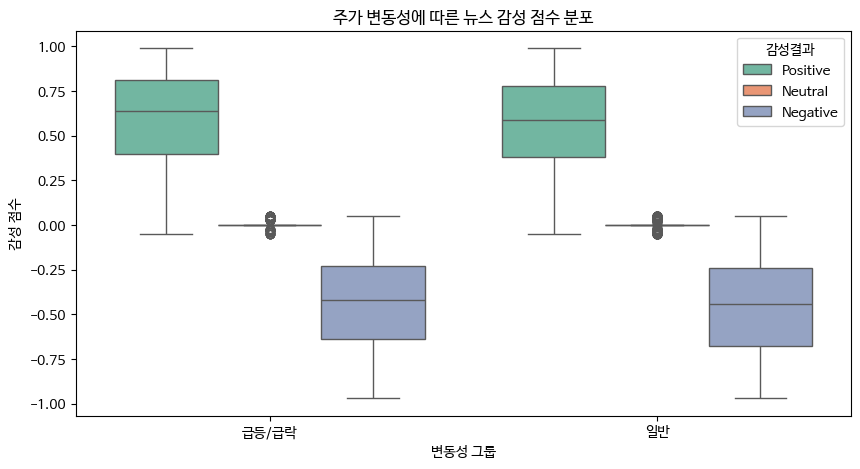

In [ ]:
volatility_stock_and_news(tesla_stock, tesla_news)

그룹 3개 기준

In [ ]:
# 주가 변동성 기준 설정 (상위/하위 10% 기준으로 급등/급락 구분)
high_threshold = stock_df["변동 %"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["변동 %"].quantile(0.1)   # 하위 10% 기준

# 급등/급락/일반 그룹 설정
def categorize_price_change(row):
    if row["변동 %"] >= high_threshold:
        return "급등"
    elif row["변동 %"] <= low_threshold:
        return "급락"
    else:
        return "일반"

# 주가 변동성 그룹을 먼저 계산
stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

# 뉴스 데이터와 주가 변동성 데이터 병합
merged_df = pd.merge(news_df, stock_df[["date", "변동성 그룹"]], on="date", how="inner")

# # 급등/급락/일반 그룹에 따른 뉴스 감성 점수 비교
# plt.figure(figsize=(8, 5))
# sns.boxplot(x="변동성 그룹", y="감성점수", data=merged_df, palette=["red", "green", "blue"])
# plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
# plt.xlabel("변동성 그룹")
# plt.ylabel("감성 점수")
# plt.show()

# 독립표본 t-검정: 급등 vs 급락, 급등 vs 일반, 급락 vs 일반 비교
# 급등 vs 급락
high_volatility_news = merged_df[merged_df["변동성 그룹"] == "급등"]["감성점수"]
low_volatility_news = merged_df[merged_df["변동성 그룹"] == "급락"]["감성점수"]

t_stat, p_value = ttest_ind(high_volatility_news, low_volatility_news, equal_var=False)
print(f"급등 vs 급락 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급등 vs 일반
normal_volatility_news = merged_df[merged_df["변동성 그룹"] == "일반"]["감성점수"]
t_stat, p_value = ttest_ind(high_volatility_news, normal_volatility_news, equal_var=False)
print(f"급등 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급락 vs 일반
t_stat, p_value = ttest_ind(low_volatility_news, normal_volatility_news, equal_var=False)
print(f"급락 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")


급등 vs 급락 t-검정 통계량: 0.5865, p-value: 0.5578
급등 vs 일반 t-검정 통계량: 0.5329, p-value: 0.5944
급락 vs 일반 t-검정 통계량: -0.2516, p-value: 0.8015


#### 종가

고점 날짜 개수: 13, 저점 날짜 개수: 13


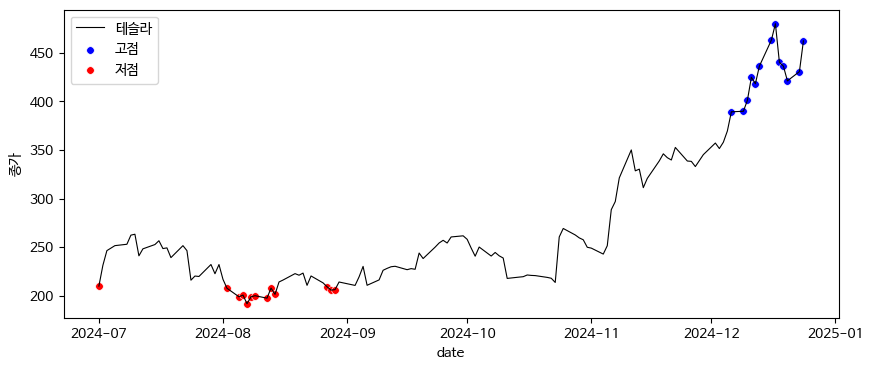

t-검정 통계량: 12.4879, p-value: 0.0000
✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)


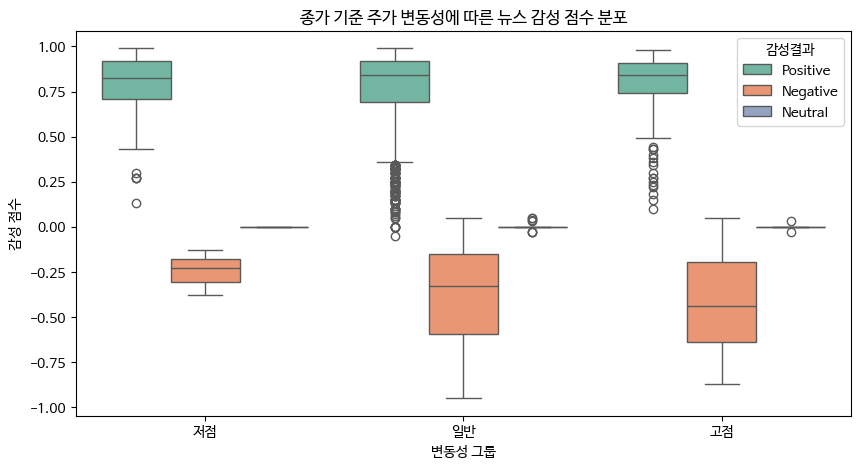

In [ ]:
close_stock_and_news(tesla_stock, tesla_news)

## CATL

In [ ]:
# CATL 주가 데이터
CATL_stock = stock_news_df.query('기업명 == "CATL"')[['기업명', 'date', '종가', '변동 %', '거래량']].drop_duplicates().reset_index(drop=True)

# CATL 뉴스 데이터
CATL_news = news.query('keyword in ["2차 전지", "전기 자동차","CATL"]').reset_index(drop=True)

#### 변동률

급등/급락 날짜 개수: 26, 변동률 적은 날짜 개수: 95


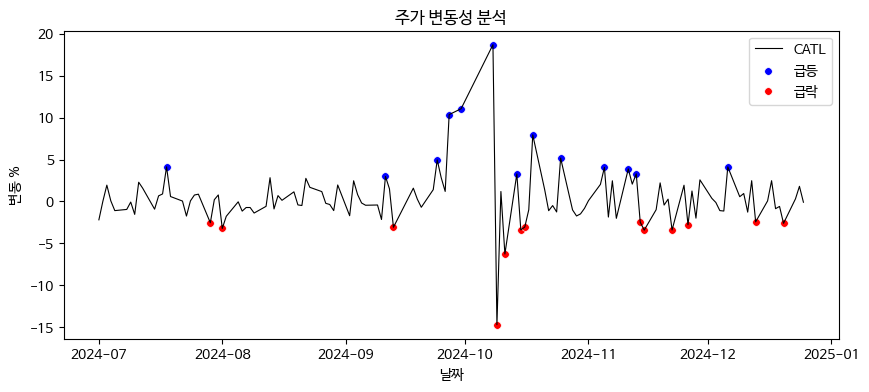

t-검정 통계량: 1.9803, p-value: 0.0477
✅ 주가 변동이 큰 날과 작은 날의 뉴스 감성 차이가 유의미함 (H₀ 기각)


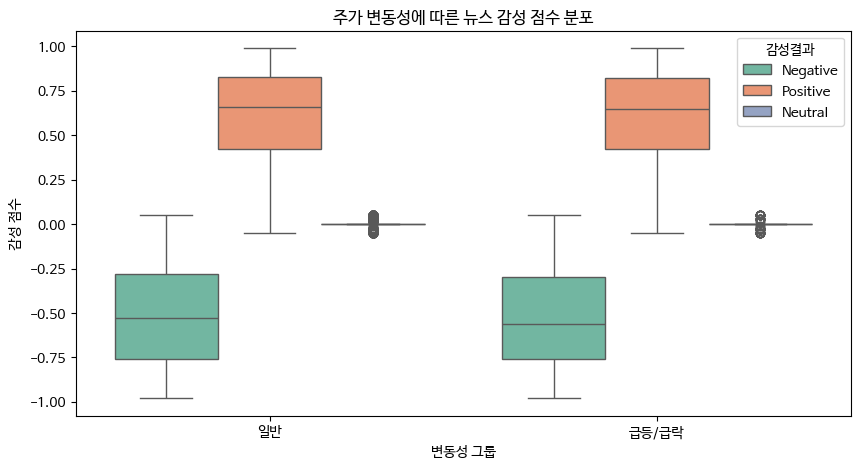

In [ ]:
volatility_stock_and_news(CATL_stock, CATL_news)

그룹 3개 기준

In [ ]:
# 주가 변동성 기준 설정 (상위/하위 10% 기준으로 급등/급락 구분)
high_threshold = stock_df["변동 %"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["변동 %"].quantile(0.1)   # 하위 10% 기준

# 급등/급락/일반 그룹 설정
def categorize_price_change(row):
    if row["변동 %"] >= high_threshold:
        return "급등"
    elif row["변동 %"] <= low_threshold:
        return "급락"
    else:
        return "일반"

# 주가 변동성 그룹을 먼저 계산
stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

# 뉴스 데이터와 주가 변동성 데이터 병합
merged_df = pd.merge(news_df, stock_df[["date", "변동성 그룹"]], on="date", how="inner")

# # 급등/급락/일반 그룹에 따른 뉴스 감성 점수 비교
# plt.figure(figsize=(8, 5))
# sns.boxplot(x="변동성 그룹", y="감성점수", data=merged_df, palette=["red", "green", "blue"])
# plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
# plt.xlabel("변동성 그룹")
# plt.ylabel("감성 점수")
# plt.show()

# 독립표본 t-검정: 급등 vs 급락, 급등 vs 일반, 급락 vs 일반 비교
# 급등 vs 급락
high_volatility_news = merged_df[merged_df["변동성 그룹"] == "급등"]["감성점수"]
low_volatility_news = merged_df[merged_df["변동성 그룹"] == "급락"]["감성점수"]

t_stat, p_value = ttest_ind(high_volatility_news, low_volatility_news, equal_var=False)
print(f"급등 vs 급락 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급등 vs 일반
normal_volatility_news = merged_df[merged_df["변동성 그룹"] == "일반"]["감성점수"]
t_stat, p_value = ttest_ind(high_volatility_news, normal_volatility_news, equal_var=False)
print(f"급등 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급락 vs 일반
t_stat, p_value = ttest_ind(low_volatility_news, normal_volatility_news, equal_var=False)
print(f"급락 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")


급등 vs 급락 t-검정 통계량: 0.5865, p-value: 0.5578
급등 vs 일반 t-검정 통계량: 0.5329, p-value: 0.5944
급락 vs 일반 t-검정 통계량: -0.2516, p-value: 0.8015


#### 종가

고점 날짜 개수: 14, 저점 날짜 개수: 13


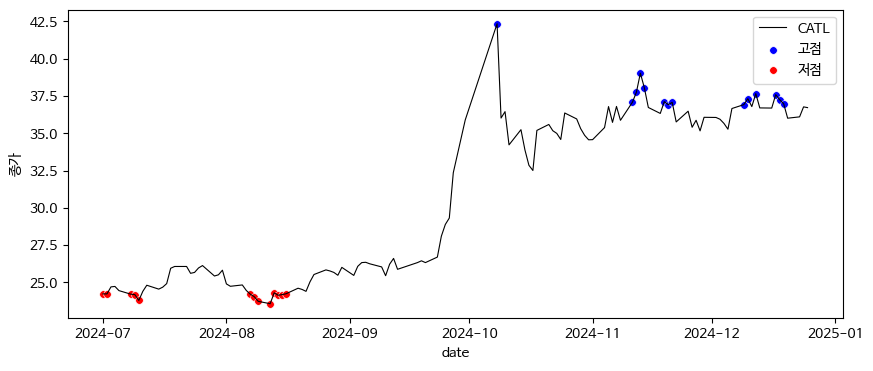

t-검정 통계량: 4.7464, p-value: 0.0000
✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)


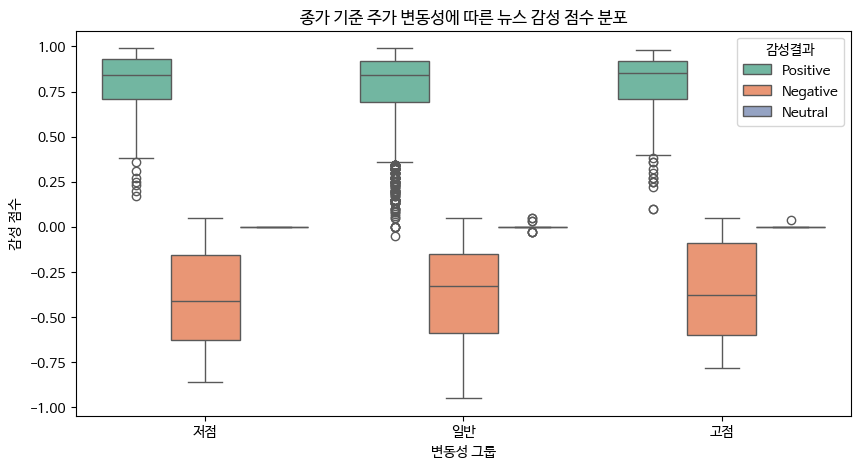

In [ ]:
close_stock_and_news(CATL_stock, CATL_news)

## BYD

In [ ]:
# BYD 주가 데이터
BYD_stock = stock_news_df.query('기업명 == "BYD"')[['기업명', 'date', '종가', '변동 %', '거래량']].drop_duplicates().reset_index(drop=True)

# BYD 뉴스 데이터
BYD_news = news.query('keyword in ["2차 전지", "전기 자동차","BYD"]').reset_index(drop=True)

#### 변동률

급등/급락 날짜 개수: 27, 변동률 적은 날짜 개수: 94


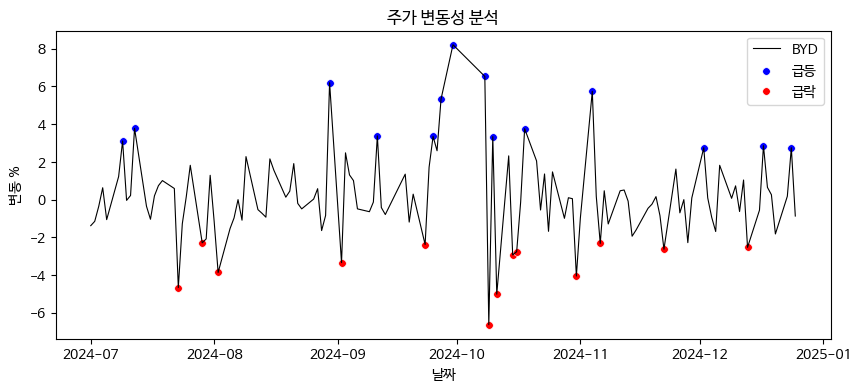

t-검정 통계량: 0.9023, p-value: 0.3669
❌ 뉴스 감성이 주가 변동성과 관계없음 (H₀ 채택)


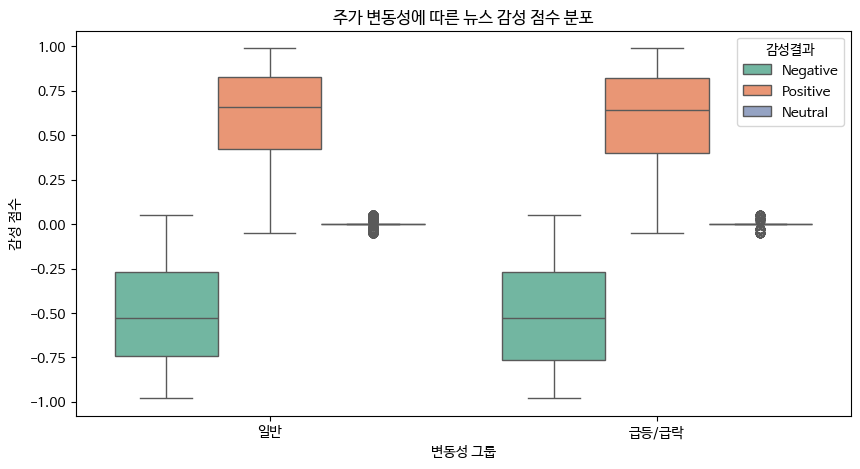

In [ ]:
volatility_stock_and_news(BYD_stock, BYD_news)

그룹 3개 기준

In [ ]:
# 주가 변동성 기준 설정 (상위/하위 10% 기준으로 급등/급락 구분)
high_threshold = stock_df["변동 %"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["변동 %"].quantile(0.1)   # 하위 10% 기준

# 급등/급락/일반 그룹 설정
def categorize_price_change(row):
    if row["변동 %"] >= high_threshold:
        return "급등"
    elif row["변동 %"] <= low_threshold:
        return "급락"
    else:
        return "일반"

# 주가 변동성 그룹을 먼저 계산
stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

# 뉴스 데이터와 주가 변동성 데이터 병합
merged_df = pd.merge(news_df, stock_df[["date", "변동성 그룹"]], on="date", how="inner")

# # 급등/급락/일반 그룹에 따른 뉴스 감성 점수 비교
# plt.figure(figsize=(8, 5))
# sns.boxplot(x="변동성 그룹", y="감성점수", data=merged_df, palette=["red", "green", "blue"])
# plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
# plt.xlabel("변동성 그룹")
# plt.ylabel("감성 점수")
# plt.show()

# 독립표본 t-검정: 급등 vs 급락, 급등 vs 일반, 급락 vs 일반 비교
# 급등 vs 급락
high_volatility_news = merged_df[merged_df["변동성 그룹"] == "급등"]["감성점수"]
low_volatility_news = merged_df[merged_df["변동성 그룹"] == "급락"]["감성점수"]

t_stat, p_value = ttest_ind(high_volatility_news, low_volatility_news, equal_var=False)
print(f"급등 vs 급락 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급등 vs 일반
normal_volatility_news = merged_df[merged_df["변동성 그룹"] == "일반"]["감성점수"]
t_stat, p_value = ttest_ind(high_volatility_news, normal_volatility_news, equal_var=False)
print(f"급등 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급락 vs 일반
t_stat, p_value = ttest_ind(low_volatility_news, normal_volatility_news, equal_var=False)
print(f"급락 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")


급등 vs 급락 t-검정 통계량: 0.5865, p-value: 0.5578
급등 vs 일반 t-검정 통계량: 0.5329, p-value: 0.5944
급락 vs 일반 t-검정 통계량: -0.2516, p-value: 0.8015


#### 종가

고점 날짜 개수: 13, 저점 날짜 개수: 13


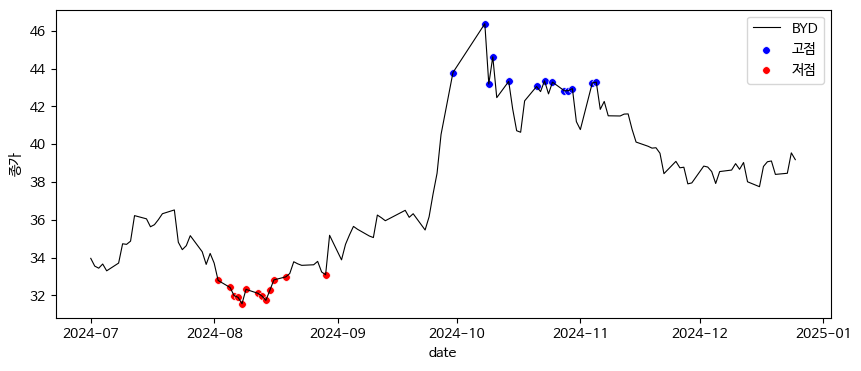

t-검정 통계량: 11.2848, p-value: 0.0000
✅ 종가가 높을 때와 낮을 때 뉴스 감성이 유의미하게 다름 (H₀ 기각)


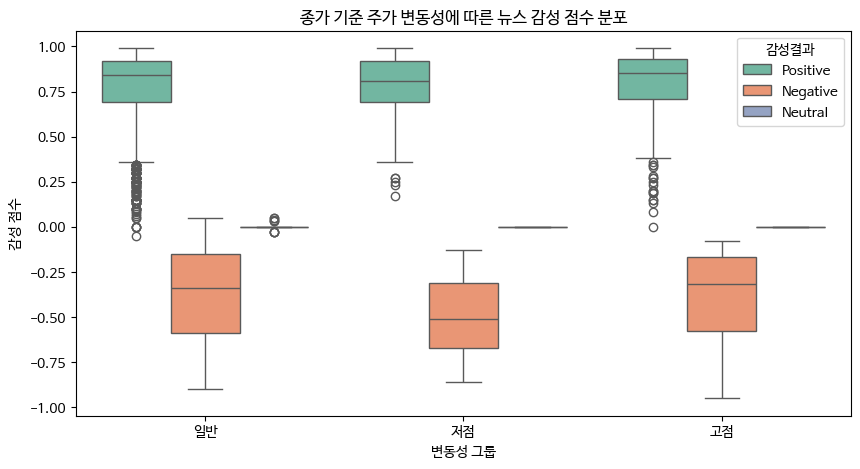

In [ ]:
close_stock_and_news(BYD_stock, BYD_news)

## 파나소닉

In [ ]:
# panasonic 주가 데이터
panasonic_stock = stock_news_df.query('기업명 == "파나소닉"')[['기업명', 'date', '종가', '변동 %', '거래량']].drop_duplicates().reset_index(drop=True)

# panasonic 뉴스 데이터
panasonic_news = news.query('keyword in ["파나소닉"]').reset_index(drop=True)

#### 변동률

급등/급락 날짜 개수: 27, 변동률 적은 날짜 개수: 95


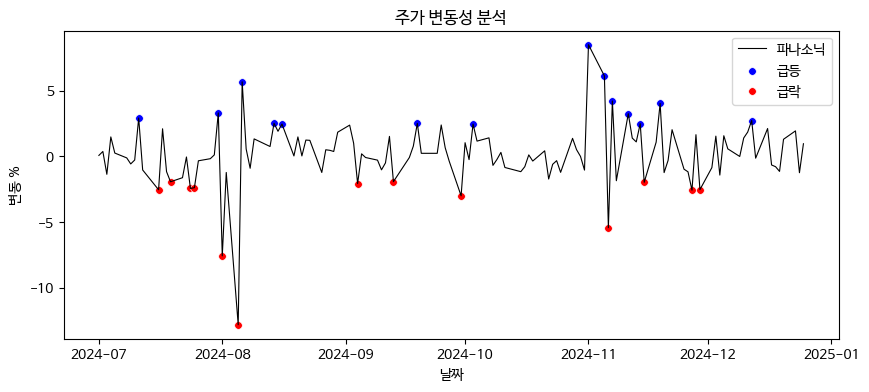

t-검정 통계량: -1.2545, p-value: 0.2117
❌ 뉴스 감성이 주가 변동성과 관계없음 (H₀ 채택)


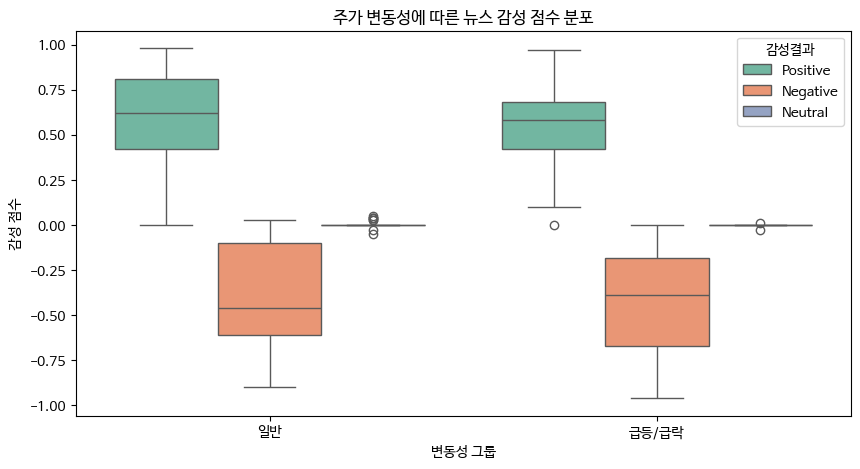

In [ ]:
volatility_stock_and_news(panasonic_stock, panasonic_news)

그룹 3개 기준

In [ ]:
# 주가 변동성 기준 설정 (상위/하위 10% 기준으로 급등/급락 구분)
high_threshold = stock_df["변동 %"].quantile(0.9)  # 상위 10% 기준
low_threshold = stock_df["변동 %"].quantile(0.1)   # 하위 10% 기준

# 급등/급락/일반 그룹 설정
def categorize_price_change(row):
    if row["변동 %"] >= high_threshold:
        return "급등"
    elif row["변동 %"] <= low_threshold:
        return "급락"
    else:
        return "일반"

# 주가 변동성 그룹을 먼저 계산
stock_df["변동성 그룹"] = stock_df.apply(categorize_price_change, axis=1)

# 뉴스 데이터와 주가 변동성 데이터 병합
merged_df = pd.merge(news_df, stock_df[["date", "변동성 그룹"]], on="date", how="inner")

# # 급등/급락/일반 그룹에 따른 뉴스 감성 점수 비교
# plt.figure(figsize=(8, 5))
# sns.boxplot(x="변동성 그룹", y="감성점수", data=merged_df, palette=["red", "green", "blue"])
# plt.title("주가 변동성에 따른 뉴스 감성 점수 분포")
# plt.xlabel("변동성 그룹")
# plt.ylabel("감성 점수")
# plt.show()

# 독립표본 t-검정: 급등 vs 급락, 급등 vs 일반, 급락 vs 일반 비교
# 급등 vs 급락
high_volatility_news = merged_df[merged_df["변동성 그룹"] == "급등"]["감성점수"]
low_volatility_news = merged_df[merged_df["변동성 그룹"] == "급락"]["감성점수"]

t_stat, p_value = ttest_ind(high_volatility_news, low_volatility_news, equal_var=False)
print(f"급등 vs 급락 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급등 vs 일반
normal_volatility_news = merged_df[merged_df["변동성 그룹"] == "일반"]["감성점수"]
t_stat, p_value = ttest_ind(high_volatility_news, normal_volatility_news, equal_var=False)
print(f"급등 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 급락 vs 일반
t_stat, p_value = ttest_ind(low_volatility_news, normal_volatility_news, equal_var=False)
print(f"급락 vs 일반 t-검정 통계량: {t_stat:.4f}, p-value: {p_value:.4f}")


급등 vs 급락 t-검정 통계량: 0.5865, p-value: 0.5578
급등 vs 일반 t-검정 통계량: 0.5329, p-value: 0.5944
급락 vs 일반 t-검정 통계량: -0.2516, p-value: 0.8015


#### 종가

고점 날짜 개수: 14, 저점 날짜 개수: 13


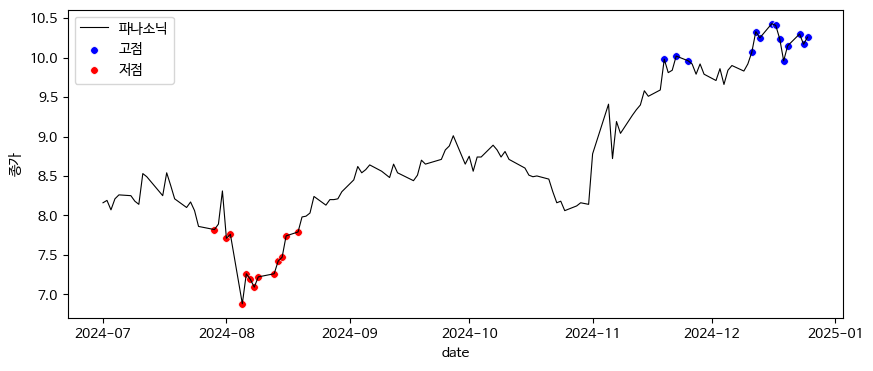

t-검정 통계량: -0.0100, p-value: 0.9921
❌ 종가 수준과 뉴스 감성은 관계 없음 (H₀ 채택)


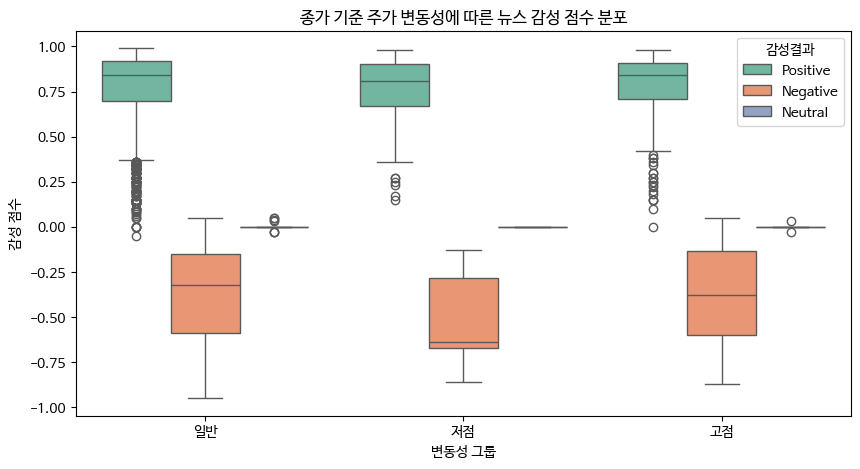

In [ ]:
close_stock_and_news(panasonic_stock, panasonic_news)